In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LinearRegression,HuberRegressor,RANSACRegressor,TheilSenRegressor,SGDRegressor
from sklearn.ensemble import RandomForestRegressor,HistGradientBoostingRegressor,AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn import neighbors
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

In [5]:
import random
import os
import torch
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.use_deterministic_algorithms(True, warn_only=True)
set_seed(42)

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
torch.cuda.empty_cache()

In [3]:
df1 = pd.read_csv('./7GHz_Tx_1_train_data_with_coords.csv')
df2 = pd.read_csv('./7GHz_Tx_2_train_data_with_coords.csv')
df3 = pd.read_csv('./7GHz_Tx_8_train_data_with_coords.csv')
df4 = pd.read_csv('./7GHz_Tx_18_train_data_with_coords.csv')
df5 = pd.read_csv('./7GHz_Tx_19_train_data_with_coords.csv')

df6 = pd.read_csv('./28GHz_Tx_1_train_data_with_coords.csv')
df7 = pd.read_csv('./28GHz_Tx_2_train_data_with_coords.csv')
df8 = pd.read_csv('./28GHz_Tx_8_train_data_with_coords.csv')
df9 = pd.read_csv('./28GHz_Tx_18_train_data_with_coords.csv')
df10 = pd.read_csv('./28GHz_Tx_19_train_data_with_coords.csv')


df11 = pd.read_csv('./800MHz_Tx_1_train_data_with_coords.csv')
df12 = pd.read_csv('./800MHz_Tx_2_train_data_with_coords.csv')
df13 = pd.read_csv('./800MHz_Tx_8_train_data_with_coords.csv')
df14 = pd.read_csv('./800MHz_Tx_18_train_data_with_coords.csv')
df15 = pd.read_csv('./800MHz_Tx_19_train_data_with_coords.csv')

In [4]:
df = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15], ignore_index=True)
# df = df.sample(frac = 0.1)

In [5]:
print(df.columns.tolist())

['distance_m', 'fspl_dB', 'umi_pathloss_dB', 'tx_height_m', 'f3_polygon_count', 'los_intersection_count', 'dist_to_first_intersection_m', 'dist_to_last_intersection_m', 'is_los', 'fresnel3_obstr_poly_area', 'los_obstr_poly_area', 'f1_polygon_count', 'fresnel1_obstr_poly_area', 'tx_sphere_poly_count', 'tx_sphere_obstr_poly_area', 'avg_tx_clutter_height', 'rx_sphere_poly_count', 'rx_sphere_obstr_poly_area', 'avg_rx_clutter_height', 'pointnet_prediction', 'measured_pathloss_dB']


In [6]:
#set the input features
X_train = df[['distance_m', 'fspl_dB', 'umi_pathloss_dB', 'tx_height_m',
              'f3_polygon_count', 'los_intersection_count', 'dist_to_first_intersection_m', 
              'dist_to_last_intersection_m', 'is_los', 'fresnel3_obstr_poly_area', 'los_obstr_poly_area',
              'f1_polygon_count', 'fresnel1_obstr_poly_area', 'tx_sphere_poly_count', 'tx_sphere_obstr_poly_area', 
              'avg_tx_clutter_height', 'rx_sphere_poly_count', 'rx_sphere_obstr_poly_area', 'avg_rx_clutter_height',
              'Tx_Lon', 'Tx_Lat', 'Rx_Lon', 'Rx_Lat']]


#set the target variable
y_train = df[['measured_pathloss_dB']]

In [7]:
print(y_train)

        measured_pathloss_dB
0                 132.634903
1                 132.655426
2                 132.677292
3                 141.309601
4                 139.641800
...                      ...
372148            122.504852
372149            121.843491
372150            118.642792
372151            115.374847
372152            114.364708

[372153 rows x 1 columns]


In [8]:
import optuna
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error

# Step 1: Data Splitting (Training and Validation Only)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Step 2: Identify and Mark Categorical Features
cat_features = [X_train.columns.get_loc(col) for col in X_train.select_dtypes(include=['object', 'category']).columns]

# Step 3: Optuna Hyperparameter Tuning
def objective(trial):
    # Define hyperparameter search space
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1500),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1),
        "depth": trial.suggest_int("depth", 1, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 1.0)
    }

    # Initialize CatBoost model with sampled parameters
    model = CatBoostRegressor(
        loss_function="MAE",
        cat_features=cat_features,
        verbose=0,  # Disable training output for optimization
        **params
    )

    # Train model
    model.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stopping_rounds=50)

    # Predict and evaluate performance
    y_pred = model.predict(X_valid)
    return np.sqrt(mean_squared_error(y_valid, y_pred)) 

# Run Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

# Get Best Parameters
best_params = study.best_params
print("Best RMSE:", study.best_value)
print("Best Parameters:", study.best_params)

# Step 4: Refit Model with Best Parameters and Early Stopping
model = CatBoostRegressor(
    loss_function="MAE",
    cat_features=cat_features,
    verbose=100,
    **best_params
)

# Train the final model with best parameters
model.fit(
    X_train, y_train,
    eval_set=(X_valid, y_valid),
    early_stopping_rounds=50
)

# Save the best parameters for reference
best_params_file = "./best_optuna_params.txt"
with open(best_params_file, "w") as f:
    f.write(str(best_params))

# Output file location
best_params_file

model.save_model("best_catboost_model.cbm")
print("Model saved as best_catboost_model.cbm")

[I 2025-10-31 19:13:05,253] A new study created in memory with name: no-name-1d2b8007-65de-4166-870a-c27745cec2a3
[I 2025-10-31 19:14:30,608] Trial 0 finished with value: 11.509295697843097 and parameters: {'iterations': 1386, 'learning_rate': 0.002955366483474128, 'depth': 10, 'l2_leaf_reg': 9.00471180326881, 'subsample': 0.662093405682934, 'colsample_bylevel': 0.5981225280855436}. Best is trial 0 with value: 11.509295697843097.
[I 2025-10-31 19:14:45,839] Trial 1 finished with value: 12.923173518216139 and parameters: {'iterations': 390, 'learning_rate': 0.0049826045456014025, 'depth': 7, 'l2_leaf_reg': 4.257010875626863, 'subsample': 0.5879399675977897, 'colsample_bylevel': 0.6142678717178828}. Best is trial 0 with value: 11.509295697843097.
[I 2025-10-31 19:14:49,280] Trial 2 finished with value: 12.452880670609959 and parameters: {'iterations': 134, 'learning_rate': 0.06640952897394513, 'depth': 1, 'l2_leaf_reg': 7.403022159657221, 'subsample': 0.5700670484729948, 'colsample_bylev

Best RMSE: 10.436166204503069
Best Parameters: {'iterations': 639, 'learning_rate': 0.05615591437117539, 'depth': 9, 'l2_leaf_reg': 2.844204723015986, 'subsample': 0.8756400053094167, 'colsample_bylevel': 0.798420040679246}
0:	learn: 19.6907229	test: 19.6490825	best: 19.6490825 (0)	total: 82.8ms	remaining: 52.8s
100:	learn: 7.9786485	test: 8.0343282	best: 8.0343282 (100)	total: 4.62s	remaining: 24.6s
200:	learn: 7.6605674	test: 7.7368751	best: 7.7368751 (200)	total: 9.83s	remaining: 21.4s
300:	learn: 7.4239061	test: 7.5256402	best: 7.5256402 (300)	total: 14.6s	remaining: 16.4s
400:	learn: 7.2446037	test: 7.3730270	best: 7.3730270 (400)	total: 19.2s	remaining: 11.4s
500:	learn: 7.1069739	test: 7.2593688	best: 7.2593688 (500)	total: 23.7s	remaining: 6.54s
600:	learn: 6.9805646	test: 7.1563322	best: 7.1563322 (600)	total: 28.5s	remaining: 1.8s
638:	learn: 6.9361170	test: 7.1204091	best: 7.1204091 (638)	total: 30.3s	remaining: 0us

bestTest = 7.120409098
bestIteration = 638

Model saved as

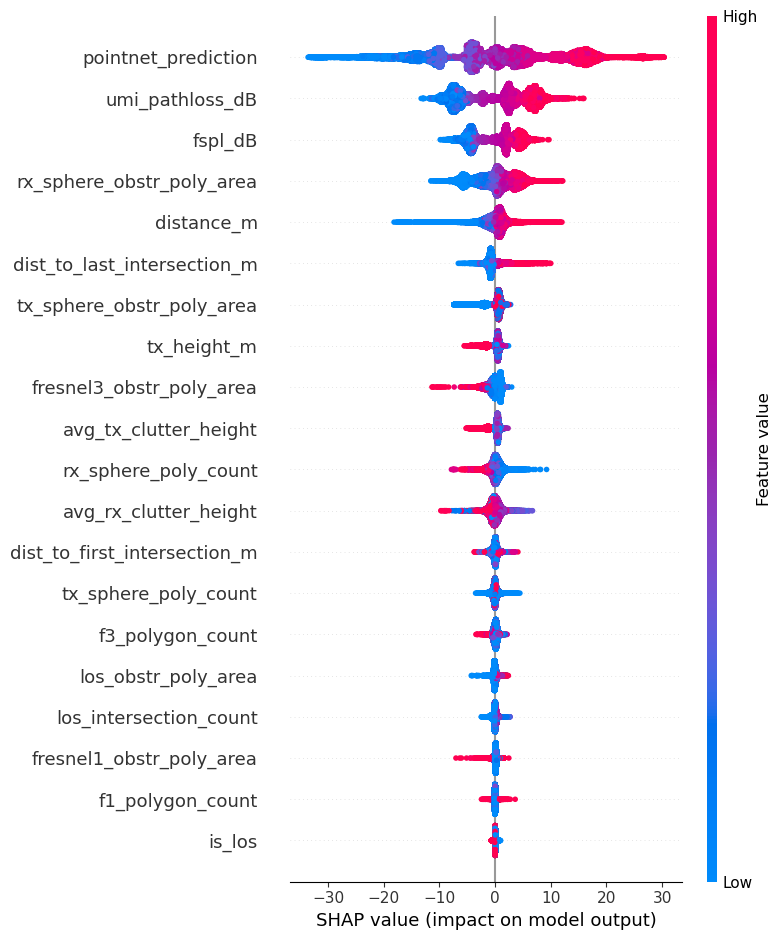

In [9]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_valid)
# Feature Importance Summary Plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_valid, max_display=len(X_valid.columns))

In [10]:
df1 = pd.read_csv('./7GHz_Tx_5_test_data_with_coords.csv')
df2 = pd.read_csv('./7GHz_Tx_9_test_data_with_coords.csv')
df3 = pd.read_csv('./7GHz_Tx_12_test_data_with_coords.csv')
df4 = pd.read_csv('./7GHz_Tx_14_test_data_with_coords.csv')
df5 = pd.read_csv('./7GHz_Tx_20_test_data_with_coords.csv')

df6 = pd.read_csv('./28GHz_Tx_5_test_data_with_coords.csv')
df7 = pd.read_csv('./28GHz_Tx_9_test_data_with_coords.csv')
df8 = pd.read_csv('./28GHz_Tx_12_test_data_with_coords.csv')
df9 = pd.read_csv('./28GHz_Tx_14_test_data_with_coords.csv')
df10 = pd.read_csv('./28GHz_Tx_20_test_data_with_coords.csv')


df11 = pd.read_csv('./800MHz_Tx_5_test_data_with_coords.csv')
df12 = pd.read_csv('./800MHz_Tx_9_test_data_with_coords.csv')
df13 = pd.read_csv('./800MHz_Tx_12_test_data_with_coords.csv')
df14 = pd.read_csv('./800MHz_Tx_14_test_data_with_coords.csv')
df15 = pd.read_csv('./800MHz_Tx_20_test_data_with_coords.csv')

In [11]:
df2 = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15], ignore_index=True)

In [12]:
X_test = df2[['distance_m', 'fspl_dB', 'umi_pathloss_dB', 'tx_height_m',
              'f3_polygon_count', 'los_intersection_count', 'dist_to_first_intersection_m', 
              'dist_to_last_intersection_m', 'is_los', 'fresnel3_obstr_poly_area', 'los_obstr_poly_area',
              'f1_polygon_count', 'fresnel1_obstr_poly_area', 'tx_sphere_poly_count', 'tx_sphere_obstr_poly_area', 
              'avg_tx_clutter_height', 'rx_sphere_poly_count', 'rx_sphere_obstr_poly_area', 'avg_rx_clutter_height',
              'Tx_Lon', 'Tx_Lat', 'Rx_Lon', 'Rx_Lat']]
y_test = df2[['measured_pathloss_dB']]

In [13]:
from catboost import CatBoostRegressor

# Load the saved model
model = CatBoostRegressor()
model.load_model("best_catboost_model.cbm")
print("Model loaded successfully!")

Model loaded successfully!


In [14]:
y_pred = model.predict(X_test)
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"Test RMSE: {rmse:.4f}")

Test RMSE: 18.3831
